<a href='http://bempp.com' style='line-height:50px'><img src='../bempp-logo.jpg' style='float:left;height:50px;margin-right:10px'> This tutorial forms part of the documentation for Bempp. Find out more at bempp.com</a>

# Electric field integral equation

This tutorial shows how to solve the electric field integral equation (EFIE) for exterior scattering problems, as described in section 5 of <a href='https://bempp.com/documentation/example-scripts-maxwell/'>Scroggs <em>et al</em> (2017)</a>.

## Background

In this tutorial, we use consider an incident wave $$\mathbf{E}^\text{inc}(\mathbf{x})=\left(\begin{array}{c}\mathrm{e}^{\mathrm{i}kz}\\0\\0\end{array}\right)$$ scattering off the unit sphere.

We let $\mathbf{E}^\text{s}$ be the scattered field and look to solve
$$
\begin{align}
\textbf{curl}\,\textbf{curl}\,\mathbf{E}-k^2\mathbf{E}&=0\quad\text{in }\Omega^\text{+},\\
\mathbf{E}\times\nu&=0\quad\text{on }\Gamma,\\
\lim_{|\mathbf{x}|\to\infty}\left(\textbf{curl}\,\mathbf{E}^\text{s}\times\frac{\mathbf{x}}{|\mathbf{x}|}-\mathrm{i}k\mathbf{E}^\text{s}\right)&=0,
\end{align}
$$

where $\mathbf{E}=\mathbf{E}^\text{s}+\mathbf{E}^\text{inc}$ is the total electric field.

### Standard EFIE
To formulate the (indirect) EFIE, we write the scattered field in the following form.

$$\mathbf{E}^\text{s}=-\mathcal{E}\Lambda,$$

where $\Lambda$ is an unknown tangential vector function. To find $\Lambda$, we use following boundary integral equation.
$$\mathsf{E}\Lambda=\gamma_\mathbf{t}^\text{+}\mathbf{E}^\text{inc}.$$

Here, $\gamma_\mathbf{t}^\text{+}$ is the tangential trace of a function, defined for $\mathbf{x}\in\Gamma$ by
$$\gamma_\mathbf{t}^\text{+}\mathbf{A}(\mathbf{x}) := \lim_{\Omega^\text{+}\ni\mathbf{x'}\to\mathbf{x}}\mathbf{A}(\mathbf{x}')\times\nu(\mathbf{x}).$$

### Calder&oacute;n preconditioned EFIE

The boundary integral equation for the EFIE is ill-conditioned, and so will be infeasible to solve for larger problems. Using properties of the <a href='https://bempp.com/2017/07/12/the-caldern-projector/'>multitrace operator</a>, we can show that $$\mathsf{E}^2=-\tfrac14\mathsf{Id}+\mathsf{H}.$$ This is a compact perturbation of the identity, and so this will lead to a well conditioned system.

The boundary integral equation for the Calder&oacute;n preconditioned EFIE is therefore
$$\mathsf{E}^2\Lambda=\mathsf{E}\gamma_\mathbf{t}^\text{+}\mathbf{E}^\text{inc}.$$
As mentioned in the <a href='https://bempp.com/2017/07/12/the-caldern-projector/'>multitrace operator</a> tutorial, the spaces used to discretise this must be chosen carefully to ensure that a stable discretisation is achieved.

## Implementation

First, we do the usual imports and set the wavenumber.

In [2]:
import bempp.api
import numpy as np

k = 3

Next, we define the grid. In <a href='https://bempp.com/documentation/example-scripts-maxwell/'>the paper</a>, we use the sphere, plus the Nasa almond (`bempp.api.shapes.almond`) and a level 1 Menger sponge (`bempp.api.shapes.menger_sponge`).

In [3]:
grid = bempp.api.shapes.sphere(h=0.1)

We will first solve the non-preconditioned EFIE. For this, we define the spaces of Raviart&ndash;Thomas (RT) and N&eacute;d&eacute;lec (NC) functions.

In [4]:
rt_space = bempp.api.function_space(grid, "RT", 0)
nc_space = bempp.api.function_space(grid, "NC", 0)

Next, we define the incendent field and its tangential trace.

In [5]:
def incident_field(x):
    return np.array([np.exp(1j*k*x[2]), 0.*x[2], 0.*x[2]])

def tangential_trace(x, n, domain_index, result):
    result[:] = np.cross(incident_field(x), n, axis=0)

grid_fun = bempp.api.GridFunction(rt_space,
                                  fun=tangential_trace,
                                  dual_space=nc_space)

We define the electric field operator, using RT functions for the domain and range spaces and NC functions for the dual space.

In [6]:
electric = bempp.api.operators.boundary.maxwell.electric_field(
    rt_space, rt_space, nc_space, k)

Finally, we solve the discretisation of the problem and print the number of iterations.

In [7]:
sol, info, iterations = bempp.api.linalg.gmres(
    electric, grid_fun, return_iteration_count=True)

print("Number of iterations:", iterations)

Number of iterations: 522


As expected, the number of iterations taken to solve the non-preconditioned system is high.

## Calder&oacute;n preconditioned EFIE

To solve the preconditioned EFIE, we begin by importing Bempp and Numpy and defining the wavenumber and incident wave as above.

In [8]:
import bempp.api
import numpy as np

k = 3

grid = bempp.api.shapes.sphere(h=0.1)

def incident_field(x):
    return np.array([np.exp(1j*k*x[2]), 0.*x[2], 0.*x[2]])

def tangential_trace(x, n, domain_index, result):
    result[:] = np.cross(incident_field(x), n, axis=0)

We define the multitrace operator, extract the spaces we will need from it, and build a grid function representing the incident wave.

In [9]:
multitrace = bempp.api.operators.boundary.maxwell.multitrace_operator(
    grid, k)
bc_space = multitrace.range_spaces[1]
snc_space = multitrace.dual_to_range_spaces[1]

grid_fun = bempp.api.GridFunction(bc_space,
                                  fun=tangential_trace,
                                  dual_space=snc_space)

We extract the electric field operators `E1` and `E2` from the multitrace operator, then form the products $\mathsf{E}^2$ and $\mathsf{E}\gamma_\mathbf{t}^\text{+}\mathbf{E}^\text{inc}$.

In [10]:
E2 = -multitrace[1,0]
E1 = multitrace[0,1]
op = E1 * E2
rhs = E1 * grid_fun

Next, we solve the discrete system and print the number of iterations.

In [11]:
sol, info, iterations = bempp.api.linalg.gmres(
    op, rhs, return_iteration_count=True)
print("Number of iterations:", iterations)

Number of iterations: 13


As expected, the preconditioned system requires a much lower number of iterations.

To plot a slice of the solution, we define a grid of points and use the representation formula to evaluate the squared electric field density at these points.

In [12]:
x_p, y_p, z_p = np.mgrid[-5:5:300j, 0:0:1j, -5:5:300j]

points = np.vstack((x_p.ravel(), y_p.ravel(), z_p.ravel()))

efie_pot = bempp.api.operators.potential.maxwell.electric_field(
    sol.space, points, k)
plot_me = incident_field(points) - efie_pot * sol

plot_me = np.real(np.sum(plot_me * plot_me.conj(), axis=0))

for i,p in enumerate(points.T):
    if np.linalg.norm(p) <= 1:
        plot_me[i] = None

Finally, we plot the slice of the solution.

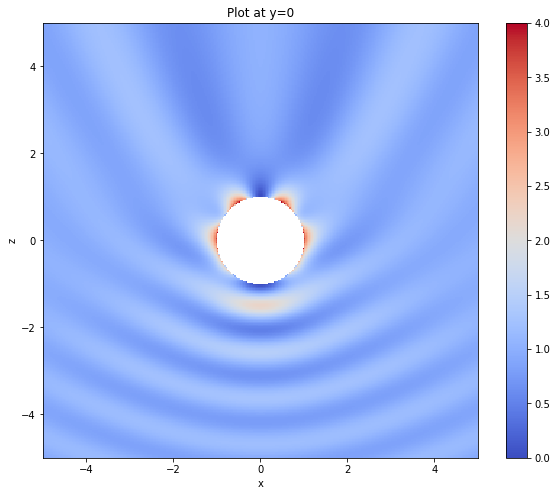

In [13]:
# The next command ensures that plots are shown within the IPython notebook
%matplotlib inline

# Adjust the figure size in IPython
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

from matplotlib import pyplot as plt

plt.imshow(plot_me.reshape((300,300)).T, origin='lower',
           extent=[-5,5,-5,5], vmin=0, vmax=4, cmap='coolwarm')
plt.colorbar()
plt.title("Plot at y=0")
plt.xlabel("x")
plt.ylabel("z")
plt.show()